## Objective
Plot matched and unmatched waveform footprints

## Setup recording and sorters

In [7]:
# region Set up notebook imports
%load_ext autoreload
%autoreload
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from multiprocessing import Pool
import sys
from pathlib import Path
from tqdm import tqdm

from src import utils
from src.recording import Recording
from src.sorters.prop_signal import PropSignal
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
RECORDING = Recording(utils.PATH_REC_DL.format('2953'), freq_min=300, freq_max=6000)

In [69]:
print("All spike times must be extracted in waveforms for this notebook to work")
PROP_WAVEFORMS_ROOT = Path("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221/log/windows_200_120/prop_signal/waveforms")

All spike times must be extracted in waveforms for this notebook to work


In [4]:
PROP_SIGNAL = PropSignal("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221/log/windows_200_120/prop_signal", RECORDING)

In [5]:
KILOSORT = Kilosort(utils.PATH_SM4_DL.format("2953"), "first", RECORDING)

Getting spike times
Getting match counts and agreement scores


100%|██████████| 90/90 [00:00<00:00, 98.87it/s] 


Num Prop.: 90
Num Kilosort2: 167
Num single matches: 39

For Prop.:
Num max matches: 47
Num unique max matches: 34

For Kilosort2:
Num max matches: 46
Num unique max matches: 36


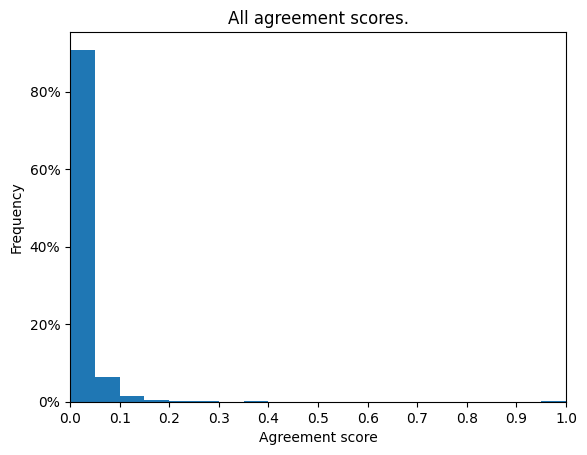

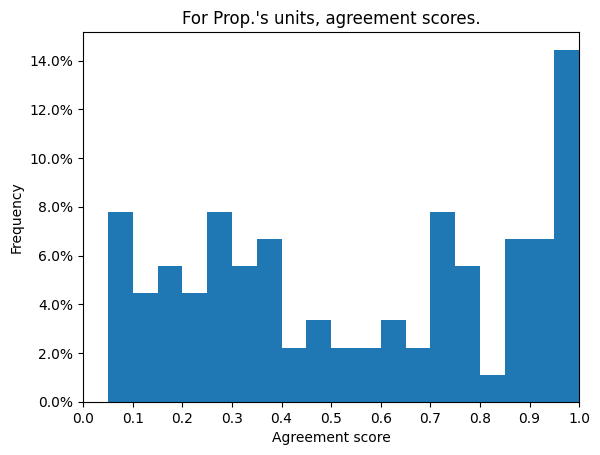

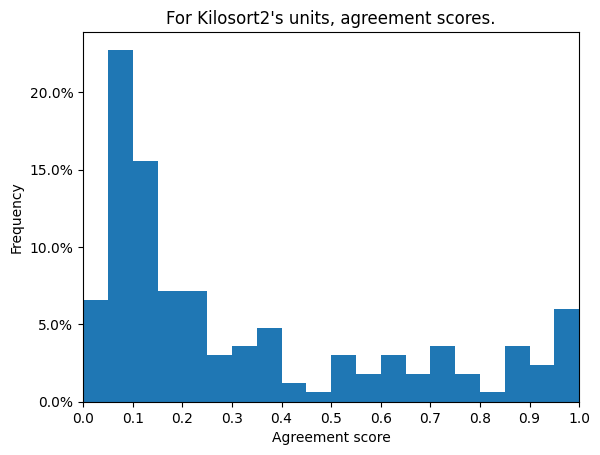

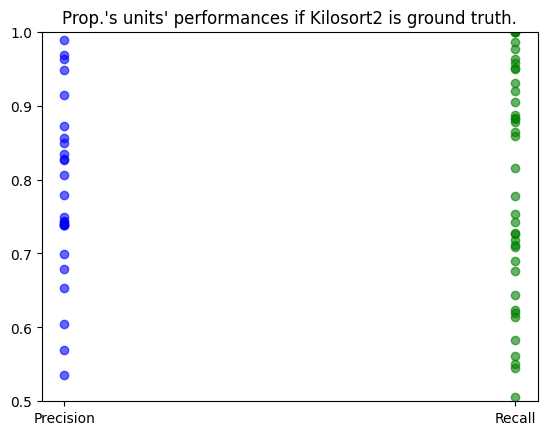

In [6]:
COMPARISON = Comparison(PROP_SIGNAL, KILOSORT, score_formula=2)

NameError: name 'axis' is not defined

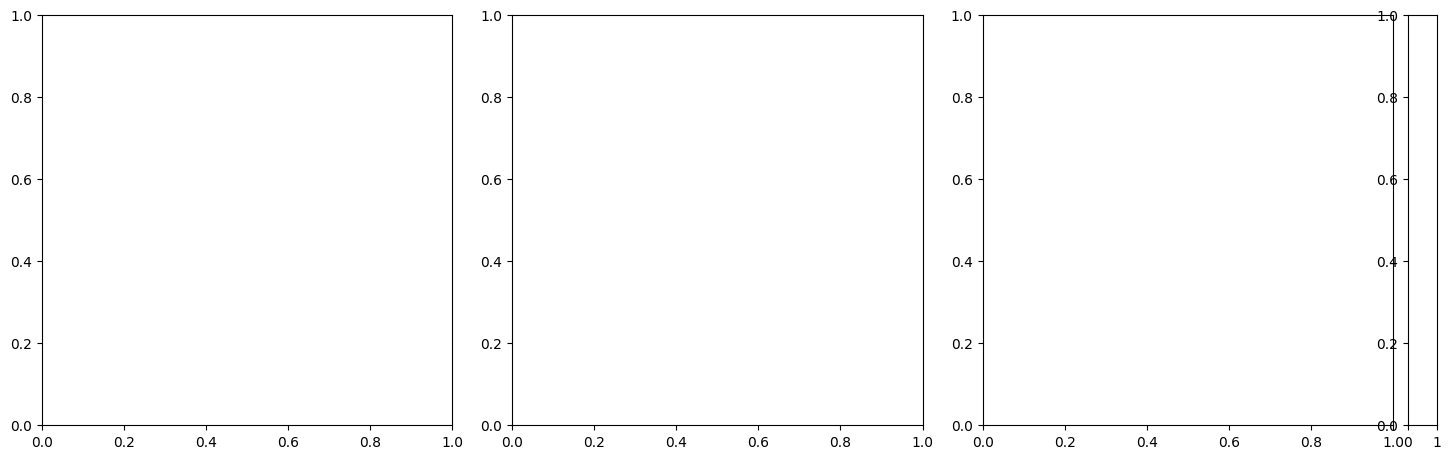

In [72]:
def get_prop_waveforms(idx_prop):
    return np.load(str(PROP_WAVEFORMS_ROOT / f"{idx_prop}.npy"), allow_pickle=True)

def shorten_waveforms(waveforms, length):
    """
    Shorten waveforms by taking window of center

    :param waveforms:
        Shape (N, num_chans, num_samples)
    :param length:
        Desired new length of waveforms

    :return:
        Shortened waveforms
    """

    center = waveforms.shape[2] // 2
    start = center-length//2
    return waveforms[:, :, start:start+length]

def shorten_template(template, length):
    """
    Shorten template by taking window of center

    :param template:
        Shape (num_chans, num_samples)
    :param length:
        Desired new length of template

    :return:
        Shortened template
    """

    center = template.shape[1] // 2
    start = center-length//2
    return template[:, start:start+length]


class Match:
    def __init__(self, idx_prop, idx_ks):
        self.prop = PROP_SIGNAL[idx_prop]
        self.ks = KILOSORT[idx_ks]

        self.score = COMPARISON.agreement_scores[idx_prop, idx_ks]
        # self.path = SAVE_PATH / f"{self.score*100:.0f}_{idx_ks}"

    def get_matching_spikes(self, delta=0.4):
        times1 = self.prop.spike_train
        times2 = self.ks.spike_train

        matched = []
        unmatched1 = []

        already_matched = set()
        for st1 in times1:
            idx = np.searchsorted(times2, st1)
            idx_left = idx - 1
            while idx_left in already_matched:
                idx_left -= 1
            if idx_left >= 0:
                left = times2[idx_left]
            else:
                left = -np.inf

            idx_right = idx
            while idx_right in already_matched:
                idx_right += 1
            if idx_right < len(times2):
                right = times2[idx_right]
            else:
                right = np.inf

            if right - st1 < st1 - left:
                if right - st1 <= delta:
                    matched.append(st1)
                    already_matched.add(idx_right)
                else:
                    unmatched1.append(st1)
            else:
                if st1 - left <= delta:
                    matched.append(st1)
                    already_matched.add(idx_left)
                else:
                    unmatched1.append(st1)

        unmatched2 = [times2[i] for i in range(len(times2)) if i not in already_matched]

        return matched, unmatched1, unmatched2

    def plot(self, save=False):
        SUBPLOTS_NAMES = (f"Matched waveforms", "Prop waveforms", "Kilosort waveforms")

        WINDOW_HALF_SIZE = 10  # length and width of window will be WINDOW_HALF_SIZE * 2
        SCALE_H = 0.4 # Multiple height of waveform by this to scale it down
        WF_WIDTH = 10

        MAX_LATENCY = 10  # In frames
        CMAP_LATENCY = plt.get_cmap("viridis", MAX_LATENCY)  # tab20c

        MAX_DOT_SIZE = 45  # For marking which channels are in prop unit
        MARKERS = "oXDs*pP1267" # For distinguishing between props in a merge

        # Find which channels to plot
        locs = RECORDING.get_channel_locations()
        nearest_chan = RECORDING.nearest_chan

        chan_center = self.prop.chan
        loc_center = locs[chan_center]

        chans, dists = nearest_chan[chan_center]

        # Adjust WINDOW_HALF_SIZE if parts of propagation are outside of max_dist
        window_half_size = WINDOW_HALF_SIZE
        for df in self.prop.df:
            for elec in df.ID:
                dist = dists[chans == elec]
                if dist > window_half_size:
                    window_half_size = dist + 60

        max_dist = np.sqrt(2) * window_half_size  # Distance from center of window to corner
        scale_y = lambda y, loc: y * SCALE_H + loc[1]

        # 1 axis with all units + 1 axis for each unit
        fig = plt.figure(figsize=(18, 6))
        grid = ImageGrid(fig, 111, # as in plt.subplot(111
                         nrows_ncols=(1, 3),
                         axes_pad=0.6,
                         cbar_location="right",
                         cbar_mode="single",
                         cbar_size="7%",
                         cbar_pad=0.15,
                         label_mode="all"
                         )

        # Setup axes
        xmin = loc_center[0] - window_half_size
        xmax = loc_center[0] + window_half_size

        ymin = loc_center[1] - window_half_size
        ymax = loc_center[1] + window_half_size

        spike_times = self.get_matching_spikes()
        waveforms =
        for i in range(3):  # matched, unmatched_prop, unmatched_kilosort
            axis = grid[i]

            axis.set_aspect("equal")

            axis.set_xlim(xmin, xmax)
            axis.set_ylim(ymin, ymax)

            axis.xaxis.set_major_locator(plt.MaxNLocator(7))
            axis.yaxis.set_major_locator(plt.MaxNLocator(7))

            ## Mark which electrodes are in the prop signal
            for i, prop in enumerate(self.prop.df):
                locs_prop = locs[prop.ID] - 5
                locs_prop[:, 1] -= 10*i
                sizes = prop.small_window_cooccurrences.values
                sizes *= MAX_DOT_SIZE/np.max(sizes)
                scatter = axis.scatter(locs_prop[:, 0], locs_prop[:, 1],
                                       s=sizes, alpha=0.6, zorder=2, marker=MARKERS[i],
                                       c=prop.latency.values,cmap=CMAP_LATENCY, vmin=0, vmax=0.5)
                axis.scatter(*locs_prop[0, :], color="black", s=sizes[0], zorder=2, marker=MARKERS[i],
                             alpha=0.6)

            # Plot footprints
            for c in chans:


        colorbar = axis.cax.colorbar(scatter, label="Latency (ms)")
        colorbar.set_ticks(np.arange(MAX_LATENCY+1)/RECORDING.get_sampling_frequency())

        if not save:
            plt.show()
        # else:
        #     fig.savefig(ROOT_PATH / f"{self.prop.id}.png", dpi=fig.dpi, bbox_inches='tight')
        #     plt.close(fig)

# matched, unmatched_prop, unmatched_ks = Match(1, 10).get_matching_spikes()
match = Match(8, 67)
matched, unmatched_prop, unmatched_ks = match.get_matching_spikes()
match.plot()

In [73]:
get_prop_waveforms(12).shape

(373, 1020, 81)

In [61]:
len(PROP_SIGNAL[8])

436

In [62]:
len(KILOSORT[67])

619

In [63]:
len(matched)

361

In [64]:
len(unmatched_prop)

75

In [65]:
len(unmatched_ks)

258

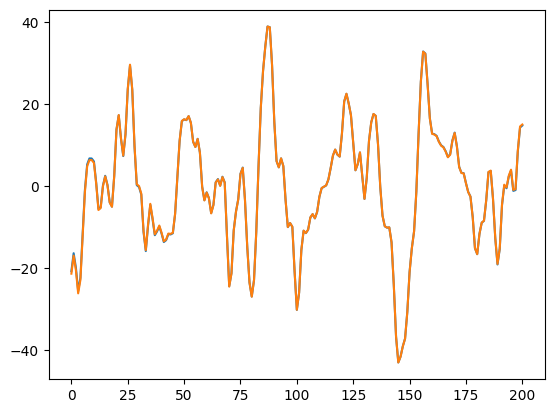

In [32]:
# Sanity check that waveforms are extracted and stored by spikesort_matlab4 in order they appear
# UNIT = KILOSORT[56]
# ST_IDX = 34
#
# st = int(UNIT.spike_train[ST_IDX] * RECORDING.get_sampling_frequency())
#
# wf = UNIT.get_waveforms()[ST_IDX, UNIT.chan, :]
# plt.plot(wf)
#
# size = UNIT.get_waveforms().shape[2]
# start_frame = st - size//2
# traces = RECORDING.get_traces_filt(start_frame, start_frame+size, UNIT.chan).flatten()
# plt.plot(traces)
#
# plt.show()

In [10]:
"""
Create matches
"""
matches = []
SAVE_PATH = Path("/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2953/230101_133514_582221/log/windows_200_120/prop_signal/max_ks_to_prop_sf2")
WF_NAMES = ["matched.npy", "unmatched_prop.npy", "unmatched_kilosort.npy"]

spikes_prop = prop_signal.get_spike_times()
spikes_ks = kilosort.get_spike_times()
for idx_ks in range(len(spikes_ks)):
    scores = comparison.agreement_scores[:, idx_ks]
    matches.append(Match(np.argmax(scores), idx_ks))

matches_sorted = sorted(matches, key=lambda m: m.score)

In [11]:
N_BEFORE = int(2 * recording.get_sampling_frequency())
N_AFTER = int(2 * recording.get_sampling_frequency())
N_CHANS = len(recording.get_channel_locations())
SF = recording.get_sampling_frequency()
WF_NAMES = ["matched.npy", "unmatched_prop.npy", "unmatched_ks.npy"]

In [337]:
# RMS = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/5rms.npy")

In [12]:
"""
If i is the index of a channel, then the ith element of self.nearest_chan is a tuple
    0) Closest channels indices: An where the 0th element is i, 1st element is closest channel, 2nd element is second closest channel, etc.
    1) Distance of channels
"""
nearest_chan = []
locs = recording.get_channel_locations()
# locs[:, 0] *= 1.5
for i in range(len(locs)):
    loc = locs[i]
    dists = np.sqrt(np.sum(np.square(locs - loc), axis=1))
    dists_sorted = np.sort(dists)
    chans_sorted = np.argsort(dists)

    nearest_chan.append((chans_sorted, dists_sorted))

In [350]:
# Choose which matches to plot
# matches_ind = np.random.choice(len(matches_sorted), size=100, replace=False)

In [366]:
# Create the plots
def job_match(idx):
    match = matches_sorted[idx]
    match.extract_templates()

    if not (match.path / "templates_spatial.png").exists():
        match.plot(save=True)

with Pool(processes=22) as pool:
    tasks = range(len(matches_sorted))
    for _ in tqdm(pool.imap(job_match, tasks), total=len(tasks)):
        pass

100%|██████████| 339/339 [21:27<00:00,  3.80s/it]


In [352]:
tasks[84]

7

In [355]:
matches_sorted[7].idx_ks

188

#### Move template plots from individual folders of each unit so folder with all plots

In [368]:
import shutil
from pathlib import Path

In [371]:
# ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230423/max_ks_to_prop")
# DEST = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230423/max_ks_to_prop/templates_spatial_plots")
# #
# for unit_folder in ROOT.iterdir():
#     unit_plot = unit_folder / "templates_spatial.png"
#     if unit_plot.exists():
#         name = unit_folder.name + ".png"
#         shutil.copy(unit_plot, DEST / name)

#### Objective
The kilosort waveforms often have more noise, but this is likely due to there not being enough kilosort only spikes to average out the noise distortions.
<br>We can test this to some extent. For cases where there are less than 200 kilosort only spikes, could you make a separate figure where matched and prop are averaged over a random selection of the same number of spikes as that there are detections of kilosort only spikes?

In [ ]:
class Match:
    def __init__(self, idx_prop, idx_ks):
        self.idx_prop = idx_prop
        self.idx_ks = idx_ks

        self.st_prop = spikes_prop[idx_prop]
        self.prop = prop_signal.props[idx_prop]

        self.st_ks = spikes_ks[idx_ks]
        self.score = comparison.agreement_scores[idx_prop, idx_ks]

        self.path = SAVE_PATH / f"{self.score*100:.0f}_{idx_ks}"

    def get_matching_spikes(self, delta=0.4):
        times1 = self.st_prop
        times2 = self.st_ks

        matched = []
        unmatched1 = []

        already_matched = set()
        for st1 in times1:
            idx = np.searchsorted(times2, st1)
            idx_left = idx - 1
            while idx_left in already_matched:
                idx_left -= 1
            if idx_left >= 0:
                left = times2[idx_left]
            else:
                left = -np.inf

            idx_right = idx
            while idx_right in already_matched:
                idx_right += 1
            if idx_right < len(times2):
                right = times2[idx_right]
            else:
                right = np.inf

            if right - st1 < st1 - left:
                if right - st1 <= delta:
                    matched.append(st1)
                    already_matched.add(idx_right)
                else:
                    unmatched1.append(st1)
            else:
                if st1 - left <= delta:
                    matched.append(st1)
                    already_matched.add(idx_left)
                else:
                    unmatched1.append(st1)

        unmatched2 = [times2[i] for i in range(len(times2)) if i not in already_matched]

        return matched, unmatched1, unmatched2

    def extract_templates(self):
        self.path.mkdir(parents=True, exist_ok=True)

        num_matches = len(self.st_ks) * self.score
        num_ks_only = len(self.st_ks) - num_matches

        for name, spike_times in zip(WF_NAMES, self.get_matching_spikes()):
            if len(spike_times) == 0 :
                np.save(self.path / name, np.array([]))
                continue

            MAX_SPIKES = num_ks_only
            if len(spike_times) > MAX_SPIKES:
                spike_times = np.array(spike_times)[np.random.choice(len(spike_times), size=MAX_SPIKES, replace=False)]

            temp = np.zeros((len(spike_times), N_CHANS, N_BEFORE + 1 + N_AFTER), dtype="float32")
            for i, st in enumerate(spike_times):
                st = int(st * SF)
                traces = recording.get_traces_filt(st-N_BEFORE, st+N_AFTER+1)
                if traces.shape[1] == temp.shape[2]:
                    temp[i, :, :] = traces
                else:
                    if st-N_BEFORE < 0:
                        temp[i, :, :traces.shape[1]] = traces
                    else:
                        temp[i, :, -traces.shape[1]:] = traces
            np.save(self.path / name, temp)

    def plot(self, save=False):
        SUBPLOTS_NAMES = (f"Matched waveforms", "Prop waveforms", "Kilosort waveforms")

        MAX_WAVEFORMS = 200  # Maximum number of waveforms to plot for a channel

        WINDOW_HALF_SIZE = 90  # length and width of window will be WINDOW_HALF_SIZE * 2
        SCALE_H = 0.03 # Multiple height of waveform by this to scale it down

        CMAP = plt.get_cmap("viridis")

        MAX_DOT_SIZE = 55  # For marking which channels are in prop unit
        MARKERS = "o*^XD<>" # For distinguishing between props in a merge

        fig, subplots = plt.subplots(1, 3, figsize=(9, 6), tight_layout=True)
        fig.suptitle(f"Prop: {self.idx_prop}|{len(self.st_prop)}. "
                     f"Kilosort: {self.idx_ks}|{len(self.st_ks)}. "
                     f"Score: {self.score:.3f}")

        chan_center = self.prop[0].ID[0]

        for axis, axis_name, wf_name in zip(subplots, SUBPLOTS_NAMES, WF_NAMES):
            waveforms = np.load(self.path / wf_name)
            templates = np.mean(waveforms, axis=0)

            # If waveforms is empty
            if waveforms.size == 0: continue

            # waveforms = waveforms[:, self.prop[0].ID[0], :]
            # template = np.mean(waveforms, axis=0)
            # a.plot(waveforms.T, c="#aaaaaa", alpha=0.5)
            # a.plot(template, c="black")

            axis.set_title(axis_name)
            axis.set_aspect("equal")
            axis.set_xlabel("x (μm)")
            axis.set_ylabel("y (μm)")

            chans, dists = nearest_chan[chan_center]
            loc_center = locs[chan_center]
            max_dist = np.sqrt(2) * WINDOW_HALF_SIZE  # Distance from center of window to corner

            axis.set_xlim(2, 68)  # 11, 59
            axis.set_ylim(loc_center[1]-WINDOW_HALF_SIZE, loc_center[1]+WINDOW_HALF_SIZE)

            scale = lambda y: y * SCALE_H + loc[1]

            # Plot each channel waveform
            for c in chans:
                loc = locs[c]
                if np.sqrt(np.sum(np.square(loc - loc_center))) >= max_dist:
                    break
                x_values = np.linspace(loc[0]-7, loc[0]+7, waveforms.shape[2])

                # Plot individual waveforms
                for w, wf in enumerate(waveforms[:, c, :]):
                    if w == MAX_WAVEFORMS: break
                    axis.plot(x_values, scale(wf), c="#cccccc", alpha=0.5)

                # Plot template
                temp = templates[c, :]
                # axis.plot(x_values, y_values, c="red" if c == chan_center else "black")
                axis.plot(x_values, scale(temp), "black")

                # Plot 5RMS
                axis.plot(x_values, [scale(-RMS[c])] * len(x_values), c="red", alpha=0.8)

            # Mark which electrodes are in the prop signal
            for i, prop in enumerate(self.prop):  # Could be multiple because of merging
                locs_prop = locs[prop.ID.values] - 4
                locs_prop[:, 1] -= 4 * i  # Multiple dots for merged propagations
                latencies = prop.latency.values
                sizes = prop.small_window_cooccurrences.values
                sizes *= MAX_DOT_SIZE/np.max(sizes)
                scatter = axis.scatter(locs_prop[:, 0], locs_prop[:, 1], c=latencies, s=sizes, zorder=10, cmap=CMAP,
                                       marker=MARKERS[i])

                # Mark which dot is the first electrode
                axis.scatter(*locs_prop[0, :], color="red", s=sizes[0], zorder=12, cmap=CMAP, marker=MARKERS[i])

        plt.colorbar(scatter, label="Latency (ms)", location="right", ax=axis)

        if not save:
            plt.show()
        else:
            plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230423/max_ks_to_prop/templates_spatial_less_200/{self.path.name}.png")
            plt.close(fig)

In [ ]:
print("CHECK ORANGE STICKY NOTE IN PHOTOS FOR UPDATES")

In [375]:
select_ind = []
for (match) in matches_sorted:
    num_matches = len(match.st_ks) * match.score
    if (num_matches / len(match.st_ks)) != match.score:
        print("uh oh")

In [ ]:
# Create the plots
def job_match(idx):
    match = matches_sorted[idx]
    match.extract_templates()

    if not (match.path / "templates_spatial.png").exists():
        match.plot(save=True)

with Pool(processes=22) as pool:
    tasks = range(len(matches_sorted))
    for _ in tqdm(pool.imap(job_match, tasks), total=len(tasks)):
        pass